In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("C:/Users/AKASH HN/Downloads/Dataset/Movies Dataset.csv")
data = data.dropna()
data.head()

,Movie Name,Release Year,Duration,IMDB Rating,Metascore,Votes,Genre,Director,Cast,Gross
0,The Godfather,1972,175,9.2,100.0,"2,002,655","Crime, Drama",Francis Ford Coppola,Marlon Brando,$134.97M
1,The Godfather Part II,1974,202,9.0,90.0,"1,358,608","Crime, Drama",Francis Ford Coppola,Al Pacino,$57.30M
2,Ordinary People,1980,124,7.7,86.0,"56,476",Drama,Robert Redford,Donald Sutherland,$54.80M
3,Lawrence of Arabia,1962,218,8.3,100.0,"313,044","Adventure, Biography, Drama",David Lean,Peter O'Toole,$44.82M
5,Close Encounters of the Third Kind,1977,138,7.6,90.0,"216,050","Drama, Sci-Fi",Steven Spielberg,Richard Dreyfuss,$132.09M


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1870 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Movie Name    1870 non-null   object 
 1   Release Year  1870 non-null   object 
 2   Duration      1870 non-null   int64  
 3   IMDB Rating   1870 non-null   float64
 4   Metascore     1870 non-null   float64
 5   Votes         1870 non-null   object 
 6   Genre         1870 non-null   object 
 7   Director      1870 non-null   object 
 8   Cast          1870 non-null   object 
 9   Gross         1870 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 160.7+ KB


#### Distribution of data

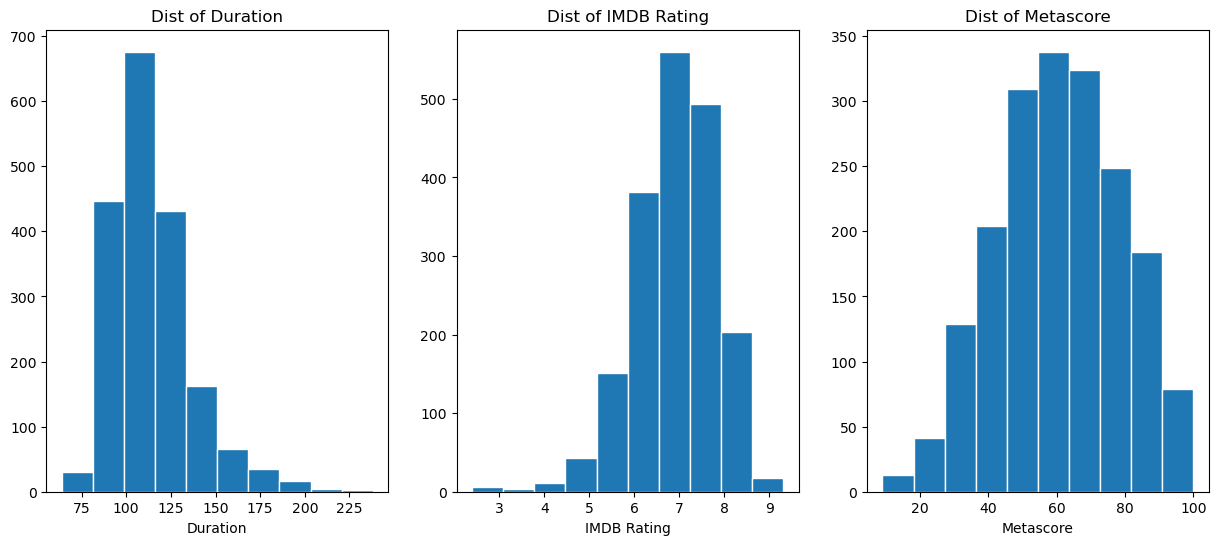

In [4]:
cols = ['Duration', 'IMDB Rating', 'Metascore']

fig,ax = plt.subplots(1,3, figsize = (15,6))

for i, col in enumerate(cols):
    ax[i].hist(data[col], edgecolor = 'white')
    ax[i].set_title(f'Dist of {col}')
    ax[i].set_xlabel(col)
    
plt.show()

#### Common Generes

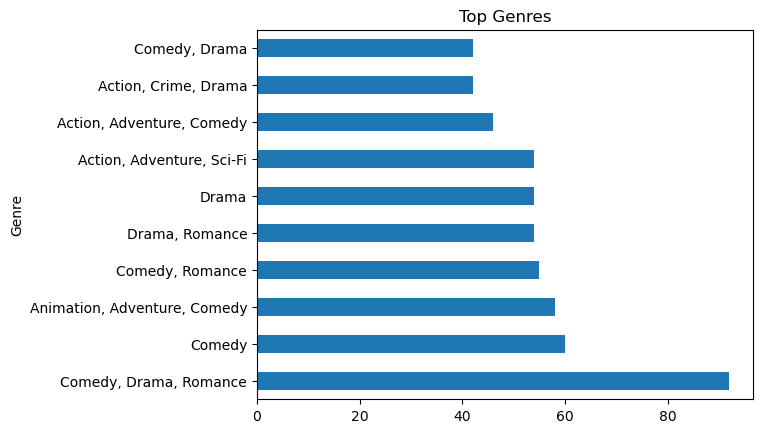

In [6]:
genre_vals = data['Genre'].value_counts().sort_values(ascending = False)[:10]
genre_vals.plot.barh()
plt.title('Top Genres')
plt.show()

### Movies with highest average rating

In [7]:
data.groupby('Movie Name')['IMDB Rating'].mean().sort_values(ascending = False)

Movie Name
The Shawshank Redemption                         9.3
The Godfather                                    9.2
The Lord of the Rings: The Return of the King    9.0
Schindler's List                                 9.0
12 Angry Men                                     9.0
                                                ... 
Dragonball Evolution                             2.5
Battlefield Earth                                2.5
Alone in the Dark                                2.4
Epic Movie                                       2.4
Glitter                                          2.4
Name: IMDB Rating, Length: 1854, dtype: float64

### Movies with highest sum of rating

In [9]:
data.groupby('Movie Name')['IMDB Rating'].sum().sort_values(ascending = False)

Movie Name
King Kong               15.1
Dawn of the Dead        15.1
Notorious               14.6
Lolita                  14.3
Ocean's Eleven          14.2
                        ... 
Dragonball Evolution     2.5
Battlefield Earth        2.5
Epic Movie               2.4
Alone in the Dark        2.4
Glitter                  2.4
Name: IMDB Rating, Length: 1854, dtype: float64

#### Creating “soup” containing all of the metadata information 

In [26]:
def clean_data(row):
    if isinstance(row, list):
        return [str.lower(i.replace(",", "")) for i in row]
    else:
        if isinstance(row, str):
            return str.lower(row.replace(",", ""))
        else:
            return " "

features = ['Cast', 'Director', 'Genre']
for feature in features:
    data[feature] = data[feature].apply(clean_data)


In [22]:
data = data.drop_duplicates('Movie Name')
def create_soup(features):
    return ''.join(features['Cast']) + '' + features['Director'] + ' ' + ''.join(features['Genre'])


data["soup"] = data.apply(create_soup, axis=1)
print(data["soup"].head())

0        marlonbrandofrancisfordcoppola crimedrama
1            alpacinofrancisfordcoppola crimedrama
2              donaldsutherlandrobertredford drama
3    petero'tooledavidlean adventurebiographydrama
4       richarddreyfussstevenspielberg dramasci-fi
Name: soup, dtype: object


##### Movie recondation works by the help of metadata

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

count_vectorizer = CountVectorizer(stop_words="english")
count_matrix = count_vectorizer.fit_transform(data["soup"])

print(count_matrix.shape)

cosine_sim = cosine_similarity(count_matrix, count_matrix) 
print(cosine_sim.shape)

data = data.reset_index()
indices = pd.Series(data.index, index=data['Movie Name'])

(1854, 1983)
(1854, 1854)


#### Creating a movie recondation system

In [24]:
def recommend(title, cosine_sim=cosine_sim):
    idx = indices[title]
    similarity_scores = list(enumerate(cosine_sim[idx]))
    similarity_scores= sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores= similarity_scores[1:11]
    # (a, b) where a is id of movie, b is similarity_scores

    movies_indices = [ind[0] for ind in similarity_scores]
    movies =data["Movie Name"].iloc[movies_indices]
    return movies

In [29]:
print("Recommendations for The Godfather")
print(recommend("The Godfather", cosine_sim))
print()
print("Recommendations for Spider-Man")
print(recommend("Spider-Man", cosine_sim))

Recommendations for The Godfather
1            The Godfather Part II
31                    12 Angry Men
114                    Taxi Driver
168                 Cool Hand Luke
176                       Brubaker
198                       Scarface
260         The Godfather Part III
322    Once Upon a Time in America
353                    Wall Street
355                  The Outsiders
Name: Movie Name, dtype: object

Recommendations for Spider-Man
1165                  Spider-Man 2
1407                  Spider-Man 3
75                        Superman
103                    Superman II
126                        Mad Max
175                    Logan's Run
180           Escape from New York
219     Terminator 2: Judgment Day
236                      Mad Max 2
246                         Aliens
Name: Movie Name, dtype: object
